Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2242 entries, 0 to 2241
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   2242 non-null   object
 1   text    2242 non-null   object
dtypes: object(2)
memory usage: 35.2+ KB
None
Validation Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   962 non-null    object
 1   text    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB
None
   label                                               text
0    sad  I do n't think I could cope with your heartbre...
1  anger  ` You could have lent it to me , " Paula said ...
2  happy  I was particularly pleased at the emphasis on ...
3  shame  ` I 'm embarrassed at the way it 's playin' up...
4  shame  Afterwards , she had been annoyed by her react...
Training

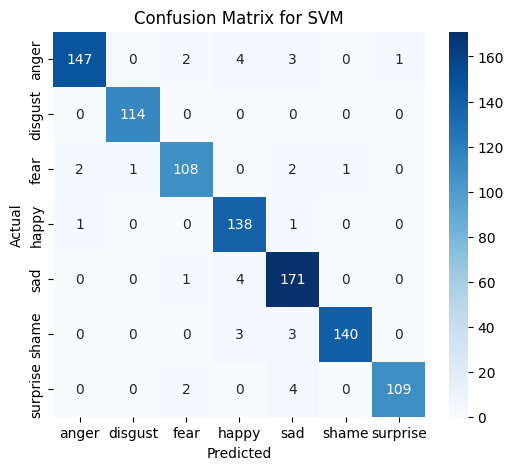

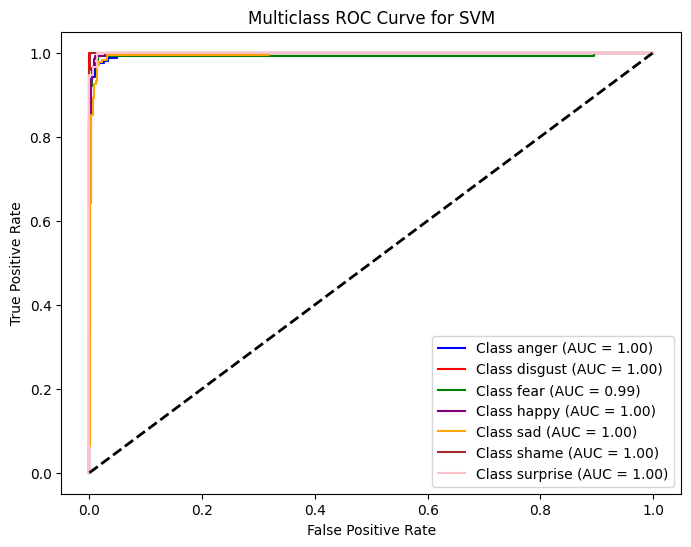

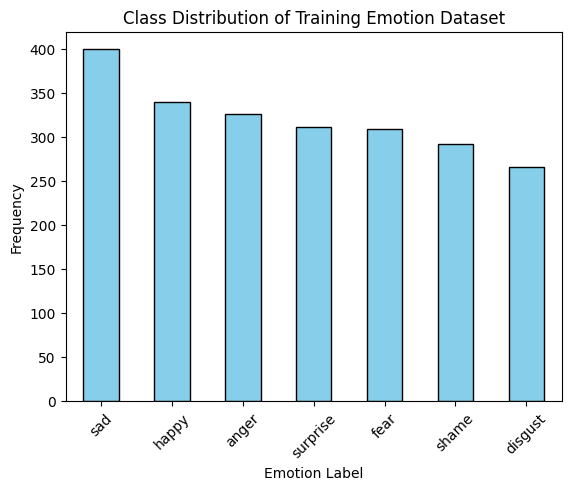

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Load training and validation datasets
train_df = pd.read_csv("training_set.csv")
val_df = pd.read_csv("validation_set.csv")

# Optionally, rename columns for clarity (assuming CSVs have similar format as before)
train_df.columns = ['label', 'text']
val_df.columns = ['label', 'text']

# Display dataset info
print("Training Data Info:")
print(train_df.info())
print("Validation Data Info:")
print(val_df.info())

# Show first few rows of the training data
print(train_df.head())

# Check class distribution in training set
print("Training Set Class Distribution:")
print(train_df['label'].value_counts())

# Convert text into TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000)  # Limit features to 5000
X_train = vectorizer.fit_transform(train_df['text'])
X_val = vectorizer.transform(val_df['text'])

# Labels
y_train = train_df['label']
y_val = val_df['label']

# Confirm shapes of the datasets
print(f"Training Data: {X_train.shape}, Validation Data: {X_val.shape}")

# Train SVM with RBF kernel on the training set
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predict on the validation set
y_pred = svm_model.predict(X_val)

# Print performance metrics on the validation set
print("Initial Accuracy:", accuracy_score(y_val, y_pred))
print("Initial Classification Report:\n", classification_report(y_val, y_pred))

# Define hyperparameter grid for Grid Search
param_grid = {
    'C': [0.1, 1, 10],          # Regularization parameter
    'gamma': ['scale', 0.1],     # Kernel coefficient
    'kernel': ['linear', 'rbf']  # Kernels to try
}

# Perform Grid Search on the training set
grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Retrieve the best model from Grid Search
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_val)

# Print best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate the optimized model on the validation set
print("Optimized Accuracy:", accuracy_score(y_val, y_pred_best))
print("Optimized Classification Report:\n", classification_report(y_val, y_pred_best))

# Compute confusion matrix for the optimized model
cm = confusion_matrix(y_val, y_pred_best)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=sorted(y_val.unique()), yticklabels=sorted(y_val.unique()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for SVM")
plt.show()

from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels for ROC curve computation
y_val_binarized = label_binarize(y_val, classes=sorted(y_val.unique()))
n_classes = y_val_binarized.shape[1]

# Get probability scores for each class from the best SVM model
y_prob = best_svm.predict_proba(X_val)

# Compute ROC curve and ROC-AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = cycle(["blue", "red", "green", "purple", "orange", "brown", "pink"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, 
             label=f'Class {sorted(y_val.unique())[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], "k--", lw=2)  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve for SVM")
plt.legend(loc="lower right")
plt.show()

# Plot class distribution for the training set
train_df['label'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Emotion Label")
plt.ylabel("Frequency")
plt.title("Class Distribution of Training Emotion Dataset")
plt.xticks(rotation=45)
plt.show()



Initial Accuracy: 0.9480249480249481
Initial Classification Report:
               precision    recall  f1-score   support

       anger       0.97      0.94      0.95       157
     disgust       1.00      0.97      0.99       114
        fear       0.99      0.95      0.97       114
       happy       0.92      0.96      0.94       140
         sad       0.84      0.98      0.91       176
       shame       1.00      0.90      0.95       146
    surprise       0.99      0.93      0.96       115

    accuracy                           0.95       962
   macro avg       0.96      0.95      0.95       962
weighted avg       0.95      0.95      0.95       962

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Optimized Accuracy: 0.9636174636174636
Optimized Classification Report:
               precision    recall  f1-score   support

       anger       0.98      0.94      0.96       157
     disgust       0.99   

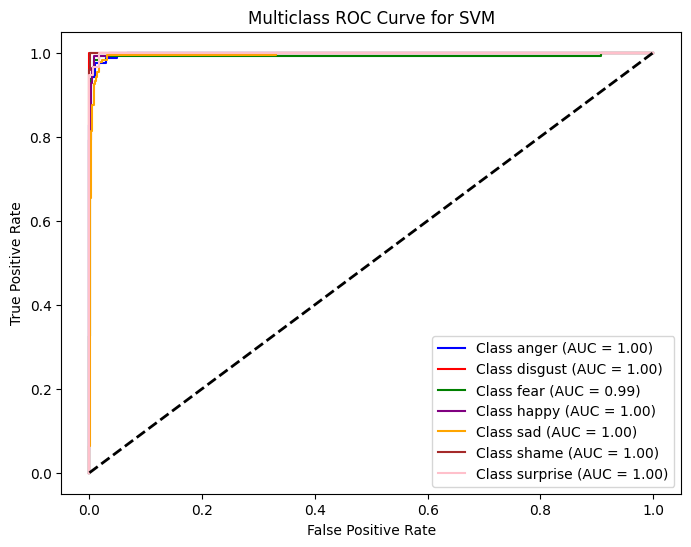

In [7]:
# Evaluate the initial SVM model on the validation set
y_pred = svm_model.predict(X_val)
print("Initial Accuracy:", accuracy_score(y_val, y_pred))
print("Initial Classification Report:\n", classification_report(y_val, y_pred))

# Define hyperparameter grid for Grid Search (using training data)
param_grid = {
    'C': [0.1, 1, 10],          # Regularization parameter
    'gamma': ['scale', 0.1],     # Kernel coefficient
    'kernel': ['linear', 'rbf']  # Kernels to try
}

# Perform Grid Search on the training set
grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Retrieve the best model and predict on the validation set
best_svm = grid_search.best_estimator_
y_pred_best = best_svm.predict(X_val)

# Print best parameters and evaluate the optimized model on the validation set
print("Best Parameters:", grid_search.best_params_)
print("Optimized Accuracy:", accuracy_score(y_val, y_pred_best))
print("Optimized Classification Report:\n", classification_report(y_val, y_pred_best))

# Compute ROC curves and ROC-AUC for multiclass classification
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels from the validation set
y_val_binarized = label_binarize(y_val, classes=sorted(y_val.unique()))
n_classes = y_val_binarized.shape[1]

# Get probability scores for each class from the best model
y_prob = best_svm.predict_proba(X_val)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = cycle(["blue", "red", "green", "purple", "orange", "brown", "pink"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, 
             label=f'Class {sorted(y_val.unique())[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], "k--", lw=2)  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve for SVM")
plt.legend(loc="lower right")
plt.show()
